In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.preprocessing import sequence
from gensim.models import Word2Vec, KeyedVectors, word2vec
import gensim
from gensim.utils import simple_preprocess
from keras.utils import to_categorical
import pickle
import h5py
from time import time

np.random.seed(7)

Using TensorFlow backend.


In [2]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('nkjp.txt', binary=False)

In [3]:
dataset = pd.read_csv('preprocessed.csv', delimiter=",")

 
# Delete All NaN values from columns=['description','rate']
dataset = dataset[dataset['description'].notnull()]
dataset = dataset[dataset['rate'].notnull()]
  
# We set all strings as lower case letters
dataset['description'] = dataset['description'].str.lower()

X = dataset['description']
y = dataset['rate']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("X_val shape: " + str(X_val.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))
print("y_val shape: " + str(y_val.shape))

X_train shape: (130701,)
X_test shape: (40845,)
X_val shape: (32676,)
y_train shape: (130701,)
y_test shape: (40845,)
y_val shape: (32676,)


In [4]:
embedding_matrix = word2vec_model.wv.syn0
print('Shape of embedding matrix: ', embedding_matrix.shape)

top_words = embedding_matrix.shape[0]
mxlen = 50
nb_classes = 3
 
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
 
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X_train = sequence.pad_sequences(sequences_train, maxlen=mxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=mxlen)
X_val = sequence.pad_sequences(sequences_val, maxlen=mxlen)
 
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

Shape of embedding matrix:  (1832700, 100)


C:\Users\Jakub\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
C:\Users\Jakub\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


Found 36017 unique tokens.


In [5]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

batch_size = 32
nb_epoch = 6

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         183270000 
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 183,387,635
Trainable params: 117,635
Non-trainable params: 183,270,000
_________________________________________________________________


In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn = model.fit(X_train, y_train, nb_epoch= nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))
score = model.evaluate(X_val, y_val)
print("Test Loss: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))


C:\Users\Jakub\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 130701 samples, validate on 32676 samples
Epoch 1/6
130701/130701 [==============================] - 235s 2ms/step - loss: 0.0324 - accuracy: 0.9924 - val_loss: 0.0254 - val_accuracy: 0.9936
Epoch 2/6
130701/130701 [==============================] - 224s 2ms/step - loss: 0.0261 - accuracy: 0.9933 - val_loss: 0.0221 - val_accuracy: 0.9937
Epoch 3/6
130701/130701 [==============================] - 224s 2ms/step - loss: 0.0243 - accuracy: 0.9934 - val_loss: 0.0212 - val_accuracy: 0.9936
Epoch 4/6
130701/130701 [==============================] - 226s 2ms/step - loss: 0.0234 - accuracy: 0.9934 - val_loss: 0.0206 - val_accuracy: 0.9938
Epoch 5/6
130701/130701 [==============================] - 225s 2ms/step - loss: 0.0225 - accuracy: 0.9936 - val_loss: 0.0211 - val_accuracy: 0.9939
Epoch 6/6
32676/32676 [==============================] - 15s 469us/step
Test Loss: 2.06%
Test Accuracy: 99.42%


In [7]:
print('Save model...')
model.save('Models/wEmbeddingLayerModel.h5')
print('Saved model to disk...')
 
print('Save Word index...')
output = open('Models/wordindex.pkl', 'wb')
pickle.dump(word_index, output)
print('Saved word index to disk...')

Save model...
Saved model to disk...
Save Word index...
Saved word index to disk...


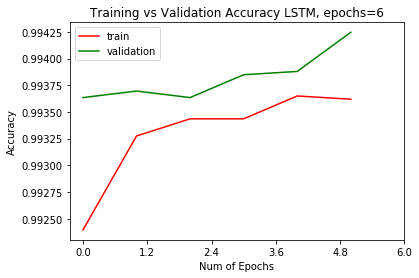

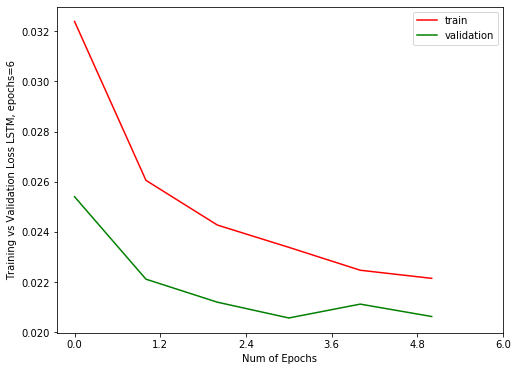

In [8]:
plt.figure(0)
plt.plot(rnn.history['accuracy'],'r')
plt.plot(rnn.history['val_accuracy'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy LSTM, epochs=6") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])
 
plt.figure(1)
plt.plot(rnn.history['loss'],'r')
plt.plot(rnn.history['val_loss'],'g')
plt.xticks(np.arange(0, nb_epoch+1, nb_epoch/5))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Training vs Validation Loss LSTM, epochs=6") # for max length = 10 and 20 epochs
plt.legend(['train', 'validation'])
plt.show()

In [9]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
 
y_pred = model.predict(X_test)
 
# Convert Y_Test into 1D array
yy_true = [np.argmax(i) for i in y_test]

yy_scores = [np.argmax(i) for i in y_pred]
 
print("Recall: " + str(recall_score(yy_true, yy_scores, average='weighted')))
print("Precision: " + str(precision_score(yy_true, yy_scores, average='weighted')))
print("F1 Score: " + str(f1_score(yy_true, yy_scores, average='weighted')))

Recall: 0.9936834373852369
Precision: 0.9916088547103269
F1 Score: 0.9913898407874167
